In [34]:
# !pip install numpy pandas matplotlib scikit-learn nafflib

In [35]:
# %pip install --user nafflib
from __future__ import annotations

import traceback
import typing

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nafflib
import numpy as np
import pandas as pd
import sklearn.cluster

In [36]:
# Load dataframe
df2 = pd.read_parquet(
    "df_chroma_data_20250822_HV_dpp_pm4e-3_woMomentumRamp_flatMD1.parquet"
)

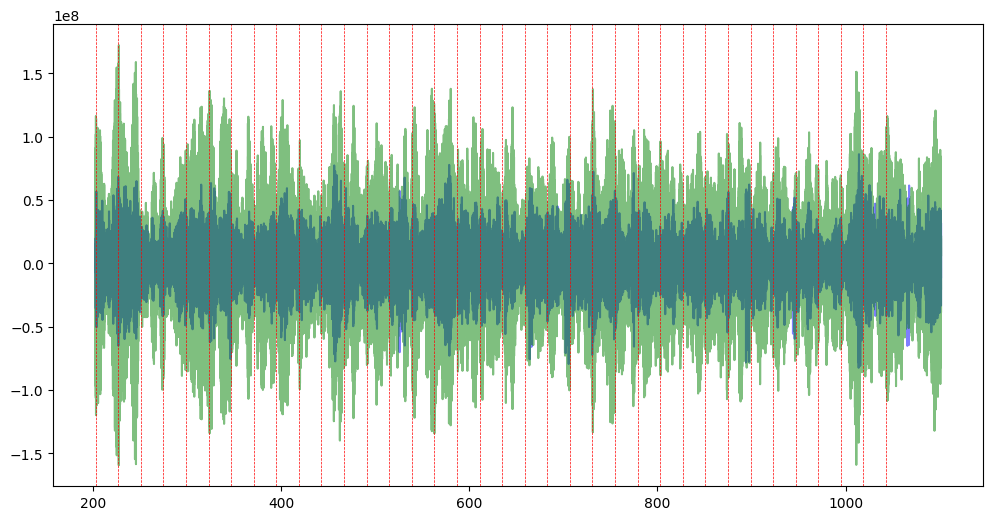

In [37]:
# Setting and checks
tune_lim = {"H": np.array([0.58, 0.645]), "V": np.array([0.54, 0.63])}
ms_ini = 200 + 3  # 10+3
chunk_size = 24  # in ms, check BBQ

N = 100  # Increased from 20 to capture more weak V tune peaks
total_duration = 1000 - ms_ini / 2
nr_of_chunks = int(total_duration / chunk_size) - 1

verbose = True  # to see the TbT slices

if verbose:
    i2look = 5
    row = df2.iloc[i2look]
    time_mask = (row["rawDataH_beamtime"] >= ms_ini) & (
        row["rawDataH_beamtime"] <= (ms_ini + total_duration)
    )
    rawDataH = row["rawDataH"][time_mask].astype(float)
    rawDataV = row["rawDataV"][time_mask].astype(float)
    rawDataH_ms = row["rawDataH_beamtime"][time_mask]
    rawDataV_ms = row["rawDataV_beamtime"][time_mask]

    f, ax = plt.subplots(figsize=(12, 6))
    ax.plot(rawDataH_ms, rawDataH, label="H", color="blue", alpha=0.5)
    ax.plot(rawDataV_ms, rawDataV, label="V", color="green", alpha=0.5)

    for i in range(nr_of_chunks):
        t_start = ms_ini + i * chunk_size
        t_end = t_start + chunk_size

        ax.axvline(x=t_start, color="red", linestyle="--", linewidth=0.5)

        # Select chunk
        maskH = rawDataH_ms >= t_start  # & (rawDataH_ms < t_end)
        maskV = rawDataV_ms >= t_start  # & (rawDataV_ms < t_end)
        tbtH = rawDataH[maskH][0:2000]
        tbtV = rawDataV[maskV][0:2000]
        # tbtH_time = rawDataV_ms[maskH][0:1980]
        # ax.plot(tbtH_time, tbtH, c='black')

In [38]:
# Loop to extract frequencies and amplitudes only (no tune identification yet)
average_tune_times_list = []
raw_frequencies_H_list = []
raw_amplitudes_H_list = []
raw_frequencies_V_list = []
raw_amplitudes_V_list = []


def sort_by_amplitude(Q: np.array, A: np.array) -> tuple[np.array, np.array]:
    sort_idx = np.argsort(np.abs(A))[::-1]
    return Q[sort_idx], A[sort_idx]


def sort_by_value(Q: np.array, A: np.array) -> tuple[np.array, np.array]:
    sort_idx = np.argsort(Q)[::-1]
    return Q[sort_idx], A[sort_idx]


def keep_valid(
    Q: np.array, A: np.array, lim: typing.Sequence
) -> tuple[np.array, np.array]:
    valid_idx = (lim[0] <= Q) & (lim[1] >= Q)
    return Q[valid_idx], A[valid_idx]


# Expanded tune limits for initial filtering (to catch coupled tunes)
expanded_tune_lim = {
    "H": np.array([0.54, 0.66]),  # Expanded to catch all potential tunes
    "V": np.array([0.54, 0.66]),  # Same range to catch coupled H tunes in V spectrum
}

for idx, row in df2.iterrows():
    print(f"{idx}/{len(df2)}")

    try:
        # Filter data starting from 200 ms
        time_mask = (row["rawDataH_beamtime"] >= ms_ini) & (
            row["rawDataH_beamtime"] <= (ms_ini + total_duration)
        )
        rawDataH = row["rawDataH"][time_mask].astype(float)
        rawDataV = row["rawDataV"][time_mask].astype(float)
        rawDataH_ms = row["rawDataH_beamtime"][time_mask]
        rawDataV_ms = row["rawDataV_beamtime"][time_mask]

        tune_times = []
        frequencies_H_chunks = []
        amplitudes_H_chunks = []
        frequencies_V_chunks = []
        amplitudes_V_chunks = []

        for i in range(nr_of_chunks):
            t_start = ms_ini + i * chunk_size
            t_end = t_start + chunk_size

            # Select chunk
            maskH = rawDataH_ms >= t_start  # & (rawDataH_ms < t_end)
            maskV = rawDataV_ms >= t_start  # & (rawDataV_ms < t_end)
            tbtH = rawDataH[maskH][0 : 990 * 2]  # selects 2 chunks (moving average)
            tbtV = rawDataV[maskV][0 : 990 * 2]  # selects 2 chunks (moving average)
            tbtH = tbtH - np.mean(tbtH)
            tbtV = tbtV - np.mean(tbtV)

            if len(tbtH) == 0 or len(tbtV) == 0:
                frequencies_H_chunks.append([])
                amplitudes_H_chunks.append([])
                frequencies_V_chunks.append([])
                amplitudes_V_chunks.append([])
                continue

            avg_time = np.mean([
                np.mean(rawDataH_ms[maskH][0:990]),
                np.mean(rawDataV_ms[maskV][0:990]),
            ])
            tune_times.append(avg_time)

            # Extract frequencies and amplitudes from both planes using EXPANDED limits
            chunk_freqs_H = []
            chunk_amps_H = []
            chunk_freqs_V = []
            chunk_amps_V = []

            try:
                QH, A, B = nafflib.get_tunes(tbtH, N=N, order=2)
                QH = 1 - QH
                QH_valid, AH_valid = keep_valid(
                    QH, A, expanded_tune_lim["H"]
                )  # Use expanded limits
                QH_valid, AH_valid = sort_by_amplitude(QH_valid, AH_valid)
                chunk_freqs_H = list(QH_valid)
                chunk_amps_H = list(AH_valid)
            except Exception:
                import traceback

                traceback.print_exc()

            try:
                QV, A, B = nafflib.get_tunes(tbtV, N=N, order=2)
                QV = 1 - QV
                QV_valid, AV_valid = keep_valid(
                    QV, A, expanded_tune_lim["V"]
                )  # Use expanded limits
                QV_valid, AV_valid = sort_by_amplitude(QV_valid, AV_valid)
                chunk_freqs_V = list(QV_valid)
                chunk_amps_V = list(AV_valid)
            except Exception:
                import traceback

                traceback.print_exc()

            # Store raw frequencies and amplitudes for this chunk
            frequencies_H_chunks.append(chunk_freqs_H)
            amplitudes_H_chunks.append(chunk_amps_H)
            frequencies_V_chunks.append(chunk_freqs_V)
            amplitudes_V_chunks.append(chunk_amps_V)

    except Exception as ex:
        print(f"Error in row {idx}: {ex}")
        print("Ignoring...")
        tune_times, frequencies_H_chunks, amplitudes_H_chunks = [], [], []
        frequencies_V_chunks, amplitudes_V_chunks = [], []

    average_tune_times_list.append(tune_times)
    raw_frequencies_H_list.append(frequencies_H_chunks)
    raw_amplitudes_H_list.append(amplitudes_H_chunks)
    raw_frequencies_V_list.append(frequencies_V_chunks)
    raw_amplitudes_V_list.append(amplitudes_V_chunks)

# Add raw data to DataFrame
df2["average_tune_times"] = average_tune_times_list
df2["raw_frequencies_H"] = raw_frequencies_H_list
df2["raw_amplitudes_H"] = raw_amplitudes_H_list
df2["raw_frequencies_V"] = raw_frequencies_V_list
df2["raw_amplitudes_V"] = raw_amplitudes_V_list

0/45
1/45
2/45
3/45
4/45
5/45
6/45
7/45
8/45
9/45
10/45
11/45
12/45
13/45
14/45
15/45
16/45
17/45
18/45
19/45
20/45
21/45
22/45
23/45
24/45
25/45
26/45
27/45
28/45
29/45
30/45
31/45
32/45
33/45
34/45
35/45
36/45
37/45
38/45
39/45
40/45
41/45
42/45
43/45
44/45


In [39]:
def cluster_single_plane(
    Q_valid: np.array, A_valid: np.array, min_cluster_separation: float = 0.02
) -> list:
    """
    Cluster tunes from a single plane using K-means.

    Returns:
        List of cluster info dicts with 'centroid', 'tunes', and 'amplitudes'
    """
    if len(Q_valid) == 0:
        return []

    if len(Q_valid) == 1:
        return [
            {
                "centroid": Q_valid[0],
                "tunes": [Q_valid[0]],
                "amplitudes": [abs(A_valid[0])],
            }
        ]

    # Apply K-means with 2 clusters, initialized at min/max to encourage separation
    cluster = sklearn.cluster.KMeans(
        n_clusters=2,
        random_state=42,
        init=np.array([[np.min(Q_valid)], [np.max(Q_valid)]]),
    )
    labels = cluster.fit_predict(Q_valid.reshape(-1, 1))
    centers = cluster.cluster_centers_.flatten()

    # Build cluster info
    cluster_info = []
    for label in np.unique(labels):
        cluster_mask = labels == label
        cluster_tunes = Q_valid[cluster_mask]
        cluster_amps = np.abs(A_valid[cluster_mask])
        centroid = centers[label]

        cluster_info.append({
            "centroid": centroid,
            "tunes": cluster_tunes,
            "amplitudes": cluster_amps,
        })

    # Sort by centroid frequency (low to high)
    return sorted(cluster_info, key=lambda x: x["centroid"])


def merge_close_clusters(clusters: list, min_separation: float) -> list:
    """
    Merge clusters that are closer than min_separation.

    Returns:
        Merged cluster list
    """
    if len(clusters) <= 1:
        return clusters

    centroids = [cluster["centroid"] for cluster in clusters]

    # Check if clusters are too close
    if np.diff(centroids)[0] < min_separation:
        # Merge into single cluster
        merged_cluster = {
            "centroid": np.mean(centroids),
            "tunes": np.concatenate([cluster["tunes"] for cluster in clusters]),
            "amplitudes": np.concatenate([
                cluster["amplitudes"] for cluster in clusters
            ]),
        }
        return [merged_cluster]

    return clusters


def select_cluster_for_plane(
    clusters: list,
    plane: str,
    other_plane_centroid: float | None = None,
    min_separation: float = 0.02,
) -> tuple[int, dict]:
    """
    Select which cluster should represent a plane (H or V).

    Returns:
        (cluster_index, cluster_dict) or (None, None) if no valid cluster
    """
    if not clusters:
        return None, None

    if len(clusters) == 1:
        cluster = clusters[0]
        # Check separation from other plane
        if (
            other_plane_centroid is not None
            and abs(cluster["centroid"] - other_plane_centroid) < min_separation
        ):
            return None, None
        return 0, cluster

    # Multiple clusters - choose based on plane preference
    if plane == "H":  # noqa: SIM108
        # H prefers higher frequency cluster
        cluster_idx = -1  # Last (highest) cluster
    else:
        # V prefers lower frequency cluster
        cluster_idx = 0  # First (lowest) cluster

    cluster = clusters[cluster_idx]

    # Check separation from other plane
    if (
        other_plane_centroid is not None
        and abs(cluster["centroid"] - other_plane_centroid) < min_separation
    ):
        return None, None

    return cluster_idx, cluster


def get_best_tune_from_cluster(cluster: dict) -> float:
    """
    Get the tune with highest amplitude from a cluster.
    """
    if not cluster or len(cluster["amplitudes"]) == 0:
        return np.nan

    best_idx = np.argmax(cluster["amplitudes"])
    return cluster["tunes"][best_idx]


def check_temporal_continuity(tune: float, prev_tune: float, max_change: float) -> bool:
    """
    Check if tune change is within acceptable limits.
    """
    if np.isnan(prev_tune) or np.isnan(tune):
        return True
    return abs(tune - prev_tune) <= max_change


def separate_tunes_with_independent_clustering(
    QH_valid: np.array,
    AH: np.array,
    QV_valid: np.array,
    AV: np.array,
    prev_QH: float = np.nan,
    prev_QV: float = np.nan,
    min_cluster_separation: float = 0.02,
    max_tune_change: float = 0.2,
) -> tuple[float, float]:
    """
    Main function: Separate H and V tunes using independent clustering.

    Algorithm:
    1. Cluster each plane independently
    2. Merge clusters that are too close together
    3. Select appropriate cluster for each plane (H=higher, V=lower)
    4. Extract best tune (highest amplitude) from each selected cluster
    5. Apply temporal continuity constraints
    """

    # Step 1: Cluster each plane independently
    h_clusters = cluster_single_plane(QH_valid, AH, min_cluster_separation)
    v_clusters = cluster_single_plane(QV_valid, AV, min_cluster_separation)

    # Step 2: Merge clusters that are too close
    h_clusters = merge_close_clusters(h_clusters, min_cluster_separation)
    v_clusters = merge_close_clusters(v_clusters, min_cluster_separation)

    # Step 3: Select clusters for each plane
    # First pass - select without considering other plane
    _h_cluster_idx, h_cluster = select_cluster_for_plane(h_clusters, "H")
    _v_cluster_idx, v_cluster = select_cluster_for_plane(v_clusters, "V")

    # Second pass - check cross-plane separation
    h_centroid = h_cluster["centroid"] if h_cluster else None
    v_centroid = v_cluster["centroid"] if v_cluster else None

    # Re-select H considering V cluster
    if h_cluster and v_centroid:
        _h_cluster_idx, h_cluster = select_cluster_for_plane(
            h_clusters, "H", v_centroid, min_cluster_separation
        )

    # Re-select V considering H cluster
    if v_cluster and h_centroid:
        _v_cluster_idx, v_cluster = select_cluster_for_plane(
            v_clusters, "V", h_centroid, min_cluster_separation
        )

    # Step 4: Extract best tunes from selected clusters
    selected_QH = get_best_tune_from_cluster(h_cluster)
    selected_QV = get_best_tune_from_cluster(v_cluster)

    # Step 5: Apply temporal continuity constraints
    if not check_temporal_continuity(selected_QH, prev_QH, max_tune_change):
        selected_QH = np.nan
    if not check_temporal_continuity(selected_QV, prev_QV, max_tune_change):
        selected_QV = np.nan

    return selected_QH, selected_QV

In [40]:
DATASET = 37
CHUNK = 0
VERBOSE = True

QH, QV = separate_tunes_with_independent_clustering(
    np.array(df2["raw_frequencies_H"][DATASET][CHUNK]),
    np.array(df2["raw_amplitudes_H"][DATASET][CHUNK]),
    np.array(df2["raw_frequencies_V"][DATASET][CHUNK]),
    np.array(df2["raw_amplitudes_V"][DATASET][CHUNK]),
    min_cluster_separation=0.003,
    max_tune_change=0.2,
)
print(f"Clustering results for dataset {DATASET}, chunk {CHUNK}:")
print(
    f"Raw data in H: {df2['raw_frequencies_H'][DATASET][CHUNK]}, {df2['raw_amplitudes_H'][DATASET][CHUNK]}"
)
print(
    f"Raw data in V: {df2['raw_frequencies_V'][DATASET][CHUNK]}, {df2['raw_amplitudes_V'][DATASET][CHUNK]}"
)
print(f"QH: {QH}, QV: {QV}")

Clustering results for dataset 37, chunk 0:
Raw data in H: [0.6318618226039308, 0.6294429325361748, 0.6330761329563983, 0.6281068888856791, 0.6309256969082437, 0.6270483895299064, 0.6343073057574374, 0.6301082224986364, 0.6263766591196009, 0.6275172907754276, 0.6256618495983308, 0.6284030955361901, 0.6317956066467494, 0.6291704963170743, 0.6267436258901928, 0.6356284513539634, 0.6277019109400443, 0.6309428721767654, 0.6248255528537341, 0.6325074742356354, 0.6142032087239666, 0.649516085421506, 0.6367352477628245], [(79043907.67203+16775134.187783927j), (67826341.92169374+20433419.18369546j), (-16472615.709069703+47442910.34511939j), (12060496.950726686+46641587.58822832j), (25889830.060350694+8992761.417233402j), (-10354506.901879843-23059925.19450943j), (-16211639.820623232-12660003.170475598j), (-14310702.872801177+203841.79861783786j), (-6021158.858638461-12291677.071010506j), (-10674874.573186917+4883527.266499652j), (-6015504.356834348-8657846.422780339j), (2240603.5918356664-9526

In [41]:
# Secondary analysis: Tune identification from raw frequencies and amplitudes
calculated_QH_list = []
calculated_QV_list = []

print("Starting tune identification analysis...")

for idx in range(len(df2)):
    print(f"Processing tune identification for row {idx}/{len(df2)}")

    try:
        # Get raw data for this measurement
        tune_times = df2.iloc[idx]["average_tune_times"]
        raw_freqs_H = df2.iloc[idx]["raw_frequencies_H"]
        raw_amps_H = df2.iloc[idx]["raw_amplitudes_H"]
        raw_freqs_V = df2.iloc[idx]["raw_frequencies_V"]
        raw_amps_V = df2.iloc[idx]["raw_amplitudes_V"]

        QH_list = []
        QV_list = []

        # Initialize previous tunes for temporal continuity
        prev_QH = np.nan
        prev_QV = np.nan

        # Process each chunk
        for i in range(len(tune_times)):
            if i < len(raw_freqs_H) and i < len(raw_freqs_V):
                # Get frequencies and amplitudes for this chunk
                chunk_freqs_H = (
                    np.array(raw_freqs_H[i]) if raw_freqs_H[i] else np.array([])
                )
                chunk_amps_H = (
                    np.array(raw_amps_H[i]) if raw_amps_H[i] else np.array([])
                )
                chunk_freqs_V = (
                    np.array(raw_freqs_V[i]) if raw_freqs_V[i] else np.array([])
                )
                chunk_amps_V = (
                    np.array(raw_amps_V[i]) if raw_amps_V[i] else np.array([])
                )

                valid_H_idx = (chunk_freqs_H > tune_lim["H"][0]) & (
                    chunk_freqs_H < tune_lim["H"][1]
                )
                valid_V_idx = (chunk_freqs_V > tune_lim["V"][0]) & (
                    chunk_freqs_V < tune_lim["V"][1]
                )

                # Apply tune identification algorithm
                selected_QH, selected_QV = separate_tunes_with_independent_clustering(
                    chunk_freqs_H[valid_H_idx],
                    chunk_amps_H[valid_H_idx],
                    chunk_freqs_V[valid_V_idx],
                    chunk_amps_V[valid_V_idx],
                    prev_QH=prev_QH,
                    prev_QV=prev_QV,
                    min_cluster_separation=0.002,
                    max_tune_change=0.008,
                )

                # # Apply original tune limits as final validation
                # if not np.isnan(selected_QH) and not (
                #     tune_lim["H"][0] <= selected_QH <= tune_lim["H"][1]
                # ):
                #     selected_QH = np.nan
                # if not np.isnan(selected_QV) and not (
                #     tune_lim["V"][0] <= selected_QV <= tune_lim["V"][1]
                # ):
                #     selected_QV = np.nan

                QH_list.append(selected_QH)
                QV_list.append(selected_QV)

                # Update previous tunes for next iteration
                if not np.isnan(selected_QH):
                    prev_QH = selected_QH
                if not np.isnan(selected_QV):
                    prev_QV = selected_QV
            else:
                QH_list.append(np.nan)
                QV_list.append(np.nan)

    except Exception as ex:
        print(f"Error in tune identification for row {idx}: {ex}")
        traceback.print_exc()
        QH_list = [np.nan] * len(tune_times) if tune_times else []
        QV_list = [np.nan] * len(tune_times) if tune_times else []

    calculated_QH_list.append(QH_list)
    calculated_QV_list.append(QV_list)

# Add identified tunes to DataFrame
df2["calculated_QH"] = calculated_QH_list
df2["calculated_QV"] = calculated_QV_list

print("Tune identification complete!")

Starting tune identification analysis...
Processing tune identification for row 0/45
Processing tune identification for row 1/45
Processing tune identification for row 2/45
Processing tune identification for row 3/45
Processing tune identification for row 4/45
Processing tune identification for row 5/45
Processing tune identification for row 6/45
Processing tune identification for row 7/45
Processing tune identification for row 8/45
Processing tune identification for row 9/45
Processing tune identification for row 10/45
Processing tune identification for row 11/45
Processing tune identification for row 12/45
Processing tune identification for row 13/45
Processing tune identification for row 14/45
Processing tune identification for row 15/45
Processing tune identification for row 16/45
Processing tune identification for row 17/45
Processing tune identification for row 18/45
Processing tune identification for row 19/45
Processing tune identification for row 20/45
Processing tune identifi

In [42]:
df2[["calculated_QH", "calculated_QV"]]

calculated_QH  \
0   [0.6347037404672986, 0.6361398686421301, 0.632...   
1   [0.6335809399352887, 0.634976407672692, 0.6355...   
2   [0.6336082219708894, 0.6349690993472942, nan, ...   
3   [0.630659286347384, nan, 0.6290969083589172, 0...   
4   [0.6280046393565082, 0.6262753696427035, 0.631...   
5   [0.6306560176055438, 0.6302923071243995, 0.626...   
6   [0.62460670230773, 0.627417718702578, 0.625735...   
7   [0.6218851473619944, 0.6256222167277502, 0.624...   
8   [0.6270447665004202, 0.625204428742248, 0.6244...   
9   [0.6215362308076233, 0.6208136467102847, 0.621...   
10  [0.6217388879441702, 0.6217696635258476, 0.622...   
11  [0.6228668961732515, 0.6216642100375327, 0.623...   
12  [0.6187259968670343, 0.6179212950804975, 0.615...   
13  [0.6196607808245076, 0.6190297548700096, 0.620...   
14  [0.6185189566699789, 0.6173428791663337, 0.617...   
15  [0.6163105388530252, nan, 0.6164244298047991, ...   
16  [0.6200240679409523, 0.6150190565425954, 0.618...   
17  [0.6169098355379783, 0.6163564778156463, 0.616...   
18  [0.6163992614180094, 0.6204185065896752, 0.617...   
19  [nan, 0.6177557773935988, 0.616616093569783, 0...   
20  [0.6178369723529219, 0.6189462628995273, 0.618...   
21  [0.6178654316676979, 0.6191149289439934, 0.620...   
22  [nan, nan, nan, 0.6179361793798019, 0.61483968...   
23  [0.6264686690021406, 0.6222642810186565, nan, ...   
24  [0.6209220557340407, nan, 0.619781025273108, 0...   
25  [0.620323432134741, 0.6182941833630675, 0.6200...   
26  [0.6179921714191923, 0.6208268762205105, 0.623...   
27  [0.6276832431462138, 0.6262970510442895, nan, ...   
28  [0.6240866048011882, nan, 0.6256396251693719, ...   
29  [0.6247252092217164, 0.6229840465025971, 0.623...   
30  [0.6265993194685504, 0.6248450859659069, 0.627...   
31  [0.6280810645324706, 0.6273391679483225, 0.632...   
32  [0.623363179516256, 0.6264251328791101, 0.6250...   
33  [0.6295488793876249, 0.6310186878270061, 0.628...   
34  [0.6298279671470542, 0.6318292930431962, 0.630...   
35  [0.630221001474052, 0.6246775783571976, 0.6295...   
36  [0.6330476384652236, 0.6330672112621026, 0.633...   
37  [nan, 0.6334118131849988, 0.6326335893671048, ...   
38  [0.629667183421922, 0.6333670328358189, nan, 0...   
39  [0.6351645981106131, nan, 0.6310700791331927, ...   
40  [nan, 0.6347629681919986, 0.6318189528411278, ...   
41  [0.63619695284361, 0.6366540368268173, 0.63618...   
42  [0.6408613490881545, 0.6382137509952561, 0.637...   
43  [nan, 0.638082600544395, 0.6353949848436808, n...   
44  [0.6401109684950683, 0.6343449066660201, 0.638...   

                                        calculated_QV  
0   [0.6086940749288806, 0.6104604089551754, 0.609...  
1   [nan, nan, 0.612334760157988, 0.60865390807611...  
2   [nan, 0.6107760908441997, nan, 0.6115785032516...  
3   [0.6089511601853748, nan, 0.6089544370975681, ...  
4   [0.6069744947264246, 0.6092668635176716, 0.607...  
5   [0.6094375965402299, 0.6082091885192356, nan, ...  
6   [0.6061228146699086, 0.6056586755829101, 0.605...  
7   [0.606816418248779, 0.6059796948624026, 0.6061...  
8   [0.607537236753525, 0.6060177404005249, 0.6044...  
9   [0.604232227470502, 0.603498221630673, 0.60341...  
10  [0.5936702371560298, nan, nan, nan, nan, nan, ...  
11  [0.6036622926500693, 0.6026697854477323, 0.602...  
12  [0.600865268336356, 0.6005263727900473, nan, 0...  
13  [0.6014623581114807, 0.6006727167888359, 0.600...  
14  [0.5959835648013088, 0.5996498520143336, 0.600...  
15  [0.5957671204991999, nan, 0.5895820001995759, ...  
16  [0.5974343803297162, 0.5911295824203133, 0.597...  
17  [0.5962503827316019, 0.5956417697488945, 0.594...  
18  [0.5920150144954339, 0.5920358857345489, 0.590...  
19  [0.5922393829488142, 0.5887194531636556, 0.594...  
20  [0.5905124848366832, 0.5913104112247038, 0.590...  
21  [0.5890917473279711, 0.5875418666307428, nan, ...  
22  [0.5888779724702351, 0.5851321010673092, 0.588...  
23  [0.5873710647822472, 0.5814179582654994, 0.584...  
24  [0.5819200578

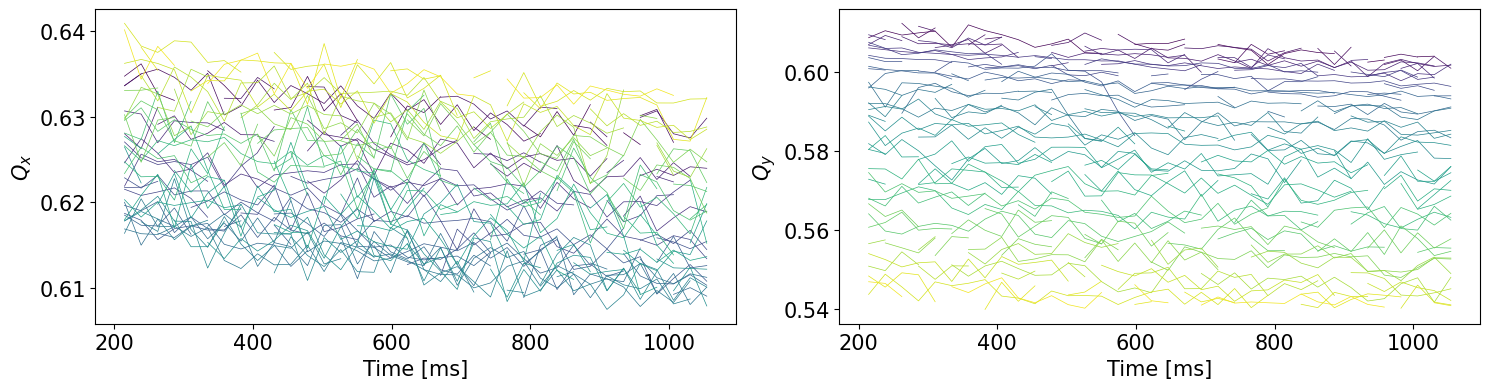

In [43]:
# Plot tune vs time
f, axs = plt.subplots(1, 2, figsize=(15, 4))
fontsize = 15

ax = axs[0]
ax.set_xlabel(r"Time [ms]", fontsize=fontsize)
ax.set_ylabel(r"$Q_x$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
for i in range(len(df2)):
    ax.plot(
        df2.iloc[i]["average_tune_times"],
        df2.iloc[i]["calculated_QH"],
        linewidth=0.5,
        c=cm.viridis(i / len(df2)),
    )

ax = axs[1]
ax.set_xlabel(r"Time [ms]", fontsize=fontsize)
ax.set_ylabel(r"$Q_y$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
for i in range(len(df2)):
    ax.plot(
        df2.iloc[i]["average_tune_times"],
        df2.iloc[i]["calculated_QV"],
        linewidth=0.5,
        c=cm.viridis(i / len(df2)),
    )

f.tight_layout()
for ext in ("png", "pdf", "svg", "webp"):
    f.savefig(f"tune_evolution_20250822_HV_dpp_pm4e-3_flatMD1.{ext}", dpi=300)

## Average chroma along flat-bottom

In [44]:
df2["average_QH"] = (
    df2["calculated_QH"].apply(lambda x: np.nanmean(x) if len(x) > 0 else np.nan) + 26
)
df2["average_QV"] = (
    df2["calculated_QV"].apply(lambda x: np.nanmean(x) if len(x) > 0 else np.nan) + 26
)
df2["std_QH"] = df2["calculated_QH"].apply(
    lambda x: np.nanstd(x) if len(x) > 0 else np.nan
)
df2["std_QV"] = df2["calculated_QV"].apply(
    lambda x: np.nanstd(x) if len(x) > 0 else np.nan
)

In [45]:
degree = 3

idx = (
    np.isfinite(df2["dp_over_p"])
    & np.isfinite(df2["average_QH"])
    & np.isfinite(df2["std_QH"])
    & (df2["std_QH"] > 0)
)
coeffs_H, cov_H = np.polyfit(
    df2["dp_over_p"][idx],
    df2["average_QH"][idx],
    degree,
    cov="unscaled",
    w=1 / df2["std_QH"][idx],
)  # Polynomial coefficients, highest power first.
err_H = np.sqrt(np.diag(cov_H))
linear_chroma_H = coeffs_H[-2]
linear_chroma_H_err = err_H[-2]
second_order_chroma_H = coeffs_H[-3] * 2 * 1
second_order_chroma_H_err = err_H[-3] * 2 * 1
third_order_chroma_H = coeffs_H[-4] * 3 * 2 * 1
third_order_chroma_H_err = err_H[-4] * 3 * 2 * 1
poly_H = np.poly1d(coeffs_H)

idx = (
    np.isfinite(df2["dp_over_p"])
    & np.isfinite(df2["average_QV"])
    & np.isfinite(df2["std_QV"])
    & (df2["std_QV"] > 0)
)
coeffs_V, cov_V = np.polyfit(
    df2["dp_over_p"][idx],
    df2["average_QV"][idx],
    degree,
    cov="unscaled",
    w=1 / df2["std_QV"][idx],
)
err_V = np.sqrt(np.diag(cov_V))
linear_chroma_V = coeffs_V[-2]
linear_chroma_V_err = err_V[-2]
second_order_chroma_V = coeffs_V[-3] * 2 * 1
second_order_chroma_V_err = err_V[-3] * 2 * 1
third_order_chroma_V = coeffs_V[-4] * 3 * 2 * 1
third_order_chroma_V_err = err_V[-4] * 3 * 2 * 1
poly_V = np.poly1d(coeffs_V)

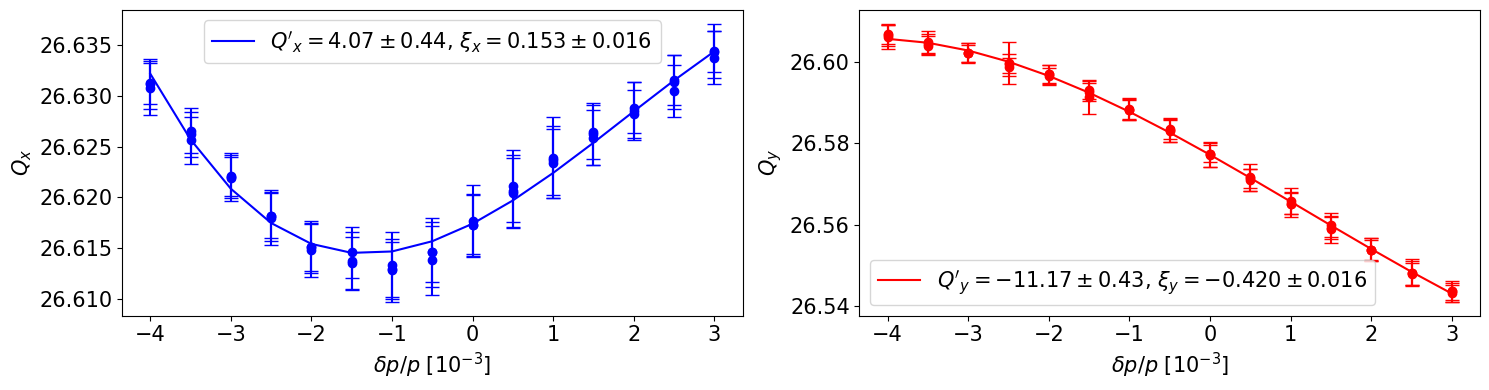

In [46]:
dppsorted = np.sort(np.unique(df2["dp_over_p"]))

qx0, qy0 = 26.621, 26.581  # 26.621, 26.581

f, axs = plt.subplots(1, 2, figsize=(15, 4))
fontsize = 15

ax = axs[0]
ax.set_xlabel(r"$\delta p/p$ [$10^{-3}$]", fontsize=fontsize)
ax.set_ylabel(r"$Q_x$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.errorbar(
    df2["dp_over_p"] * 1000,
    df2["average_QH"],
    yerr=df2["std_QH"],
    fmt="o",
    capsize=5,
    color="blue",
)
ax.plot(
    dppsorted * 1000,
    poly_H(dppsorted),
    color="blue",
    label=rf"$Q'_x = {linear_chroma_H:1.2f} \pm {linear_chroma_H_err:1.2f}$, $\xi_x = {linear_chroma_H / qx0:1.3f} \pm {linear_chroma_H_err / qx0:1.3f}$",
)
ax.legend(fontsize=fontsize)

ax = axs[1]
ax.set_xlabel(r"$\delta p/p$ [$10^{-3}$]", fontsize=fontsize)
ax.set_ylabel(r"$Q_y$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.errorbar(
    df2["dp_over_p"] * 1000,
    df2["average_QV"],
    yerr=df2["std_QV"],
    fmt="o",
    capsize=5,
    color="red",
)
ax.plot(
    dppsorted * 1000,
    poly_V(dppsorted),
    color="red",
    label=rf"$Q'_y = {linear_chroma_V:1.2f} \pm {linear_chroma_V_err:1.2f}$, $\xi_y = {linear_chroma_V / qy0:1.3f} \pm {linear_chroma_V_err / qy0:1.3f}$",
)
ax.legend(fontsize=fontsize)

f.tight_layout()
for ext in ("png", "pdf", "svg", "webp"):
    f.savefig(f"chromas_20250822_HV_dpp_pm4e-3_flatMD1.{ext}", dpi=300)

In [47]:
# Check average chromas
print("~*~*~*~*~*~*~*~*~*~*~*~*")
print(
    f"Linear chroma H: {linear_chroma_H:.3f} ± {linear_chroma_H_err:.3f}, normalized: {linear_chroma_H / qx0:.3f} ± {linear_chroma_H_err / qx0:.3f}"
)
print(
    f"Linear chroma V: {linear_chroma_V:.3f} ± {linear_chroma_V_err:.3f}, normalized: {linear_chroma_V / qy0:.3f} ± {linear_chroma_V_err / qy0:.3f}"
)
print("~*~*~*~*~*~*~*~*~*~*~*~*")
print(
    f"Second order chroma H [1e3]: {second_order_chroma_H * 1e-3:.3f} ± {second_order_chroma_H_err * 1e-3:.3f}"
)
print(
    f"Second order chroma V [1e3]: {second_order_chroma_V * 1e-3:.3f} ± {second_order_chroma_V_err * 1e-3:.3f}"
)
print("~*~*~*~*~*~*~*~*~*~*~*~*")
print(
    f"Third order chroma H [1e6]: {third_order_chroma_H * 1e-6:.3f} ± {third_order_chroma_H_err * 1e-6:.3f}"
)
print(
    f"Third order chroma V [1e6]: {third_order_chroma_V * 1e-6:.3f} ± {third_order_chroma_V_err * 1e-6:.3f}"
)
print("~*~*~*~*~*~*~*~*~*~*~*~*")
print("QPH in LSA: 0.6003")
print("QP in LSA: -0.7258")

~*~*~*~*~*~*~*~*~*~*~*~*
Linear chroma H: 4.069 ± 0.436, normalized: 0.153 ± 0.016
Linear chroma V: -11.166 ± 0.432, normalized: -0.420 ± 0.016
~*~*~*~*~*~*~*~*~*~*~*~*
Second order chroma H [1e3]: 2.269 ± 0.251
Second order chroma V [1e3]: -0.943 ± 0.229
~*~*~*~*~*~*~*~*~*~*~*~*
Third order chroma H [1e6]: -1.210 ± 0.301
Third order chroma V [1e6]: 0.811 ± 0.295
~*~*~*~*~*~*~*~*~*~*~*~*
QPH in LSA: 0.6003
QP in LSA: -0.7258


## Chroma evolution along flat-bottom

In [48]:
# Reshape dataframe wrt ctime (index)
df3 = df2[
    [
        "dp_over_p",
        "average_tune_times",
        "calculated_QH",
        "calculated_QV",
        "average_QH",
        "std_QH",
        "average_QV",
        "std_QV",
    ]
].copy()
df3_exploded = df3[
    ["dp_over_p", "average_tune_times", "calculated_QH", "calculated_QV"]
].explode(["average_tune_times", "calculated_QH", "calculated_QV"])
df3_exploded = df3_exploded.rename(
    columns={
        "average_tune_times": "ctime",
        "calculated_QH": "QH",
        "calculated_QV": "QV",
    }
)
df3_exploded = df3_exploded.dropna(subset=["QH", "QV"])
df3_reshaped = df3_exploded.groupby("ctime").agg({
    "QH": list,
    "QV": list,
    "dp_over_p": list,
})

In [49]:
# Calculate chroma for each ctime

for plane in ["H", "V"]:
    for order in ["linear", "second_order", "third_order"]:
        df3_reshaped[f"{order}_chroma_{plane}"] = np.nan
        df3_reshaped[f"{order}_chroma_{plane}_err"] = np.nan

degree = 3
for row in df3_reshaped.itertuples():
    idx = np.isfinite(row.dp_over_p) & np.isfinite(row.QH)
    coeffs_H, cov_H = np.polyfit(
        np.array(row.dp_over_p)[idx], np.array(row.QH)[idx], degree, cov=True
    )
    err_H = np.sqrt(np.diag(cov_H))
    linear_chroma_H = coeffs_H[-2]
    linear_chroma_H_err = err_H[-2]
    # second_order_chroma_H = coeffs_H[-3]
    # second_order_chroma_H_err = err_H[-3]
    # third_order_chroma_H = coeffs_H[-4]
    # third_order_chroma_H_err = err_H[-4]

    idx = np.where(np.isfinite(row.dp_over_p) & np.isfinite(row.QV))[0]
    coeffs_V, cov_V = np.polyfit(
        np.array(row.dp_over_p)[idx], np.array(row.QV)[idx], degree, cov=True
    )
    err_V = np.sqrt(np.diag(cov_V))
    linear_chroma_V = coeffs_V[-2]
    linear_chroma_V_err = err_V[-2]
    # second_order_chroma_V = coeffs_V[-3]
    # second_order_chroma_V_err = err_V[-3]
    # third_order_chroma_V = coeffs_V[-4]
    # third_order_chroma_V_err = err_V[-4]

    df3_reshaped.at[row.Index, "linear_chroma_H"] = linear_chroma_H
    df3_reshaped.at[row.Index, "linear_chroma_H_err"] = linear_chroma_H_err
    # df3_reshaped.at[row.Index, 'second_order_chroma_H'] = second_order_chroma_H
    # df3_reshaped.at[row.Index, 'second_order_chroma_H_err'] = second_order_chroma_H_err
    # df3_reshaped.at[row.Index, 'third_order_chroma_H'] = third_order_chroma_H
    # df3_reshaped.at[row.Index, 'third_order_chroma_H_err'] = third_order_chroma_H_err
    df3_reshaped.at[row.Index, "linear_chroma_V"] = linear_chroma_V
    df3_reshaped.at[row.Index, "linear_chroma_V_err"] = linear_chroma_V_err
    # df3_reshaped.at[row.Index, 'second_order_chroma_V'] = second_order_chroma_V
    # df3_reshaped.at[row.Index, 'second_order_chroma_V_err'] = second_order_chroma_V_err
    # df3_reshaped.at[row.Index, 'third_order_chroma_V'] = third_order_chroma_V
    # df3_reshaped.at[row.Index, 'third_order_chroma_V_err'] = third_order_chroma_V_err

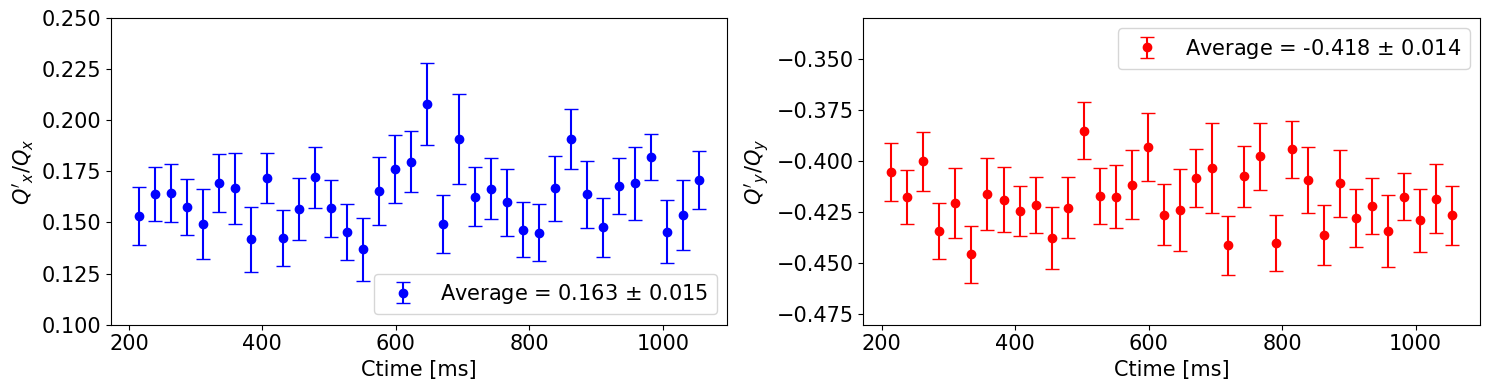

In [50]:
# Plot chroma evolution
f, axs = plt.subplots(1, 2, figsize=(15, 4))
fontsize = 15

ax = axs[0]
ax.set_xlabel(r"Ctime [ms]", fontsize=fontsize)
ax.set_ylabel(r"$Q'_x / Q_x$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.errorbar(
    df3_reshaped.index,
    df3_reshaped["linear_chroma_H"] / qx0,
    yerr=df3_reshaped["linear_chroma_H_err"] / qx0,
    fmt="o",
    capsize=5,
    color="blue",
    label=rf"Average = {np.nanmean(df3_reshaped['linear_chroma_H']) / qx0:.3f} $\pm$ {np.nanstd(df3_reshaped['linear_chroma_H']) / qx0:.3f}",
)

ax.legend(fontsize=fontsize)
ax.set_ylim(0.1, 0.25)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")

ax = axs[1]
ax.set_xlabel(r"Ctime [ms]", fontsize=fontsize)
ax.set_ylabel(r"$Q'_y / Q_y$", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.errorbar(
    df3_reshaped.index,
    df3_reshaped["linear_chroma_V"] / qy0,
    yerr=df3_reshaped["linear_chroma_H_err"] / qy0,
    fmt="o",
    capsize=5,
    color="red",
    label=rf"Average = {np.nanmean(df3_reshaped['linear_chroma_V']) / qy0:.3f} $\pm$ {np.nanstd(df3_reshaped['linear_chroma_V']) / qy0:.3f}",
)

ax.legend(fontsize=fontsize)
ax.set_ylim(-0.48, -0.33)

f.tight_layout()
for ext in ("png", "pdf", "svg", "webp"):
    f.savefig(f"linchroma_evolution_20250822_HV_dpp_pm4e-3_flatMD1.{ext}", dpi=300)